# Simple Data Augmentation with ImgAug
This notebook is based on a few of the most upvoted notebooks already in the competitions, but I adjusted the code to make data augmentation simple.

Let me know if you have any suggestions or feedback!

**This is my first public kernel, have mercy!**


In [1]:
!pip install --upgrade imgaug

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import random
import cv2
import os
        
data_path = '/kaggle/input/understanding_cloud_organization'
train_csv_path = os.path.join(data_path,'train.csv')
train_image_path = os.path.join(data_path,'train_images')
df = pd.read_csv(train_csv_path)
df.head()

     |████████████████████████████████| 829kB 2.8MB/s 
     |████████████████████████████████| 22.1MB 33.0MB/s 
ERROR: albumentations 0.3.3 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.3.0 which is incompatible.
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6


,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [2]:
# drop the rows where at least one element is missing. 
df.dropna(inplace=True)

#  split Image_Label in Image_id and Label
df['Image'] = df['Image_Label'].apply(lambda x: x.split('_')[0])
df['Label'] = df['Image_Label'].apply(lambda x: x.split('_')[1])

# drop Image_Label column
df.drop(columns='Image_Label', inplace=True)

df.head()

,EncodedPixels,Image,Label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
5,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower
7,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar


In [3]:
# credit https://www.kaggle.com/ekhtiar/eda-find-me-in-the-clouds
def rle2mask(rle_string, height, width):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rle_string (str): string of rle encoded mask
    height (int): height of the mask
    width (int): width of the mask 

    Returns: 
    numpy.array: numpy array of the mask
    '''
    
    rows, cols = height, width
    
    rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1,2)
    img = np.zeros(rows*cols, dtype=np.uint8)
    for index, length in rle_pairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

# credits: https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


from imgaug.augmentables.segmaps import SegmentationMapsOnImage
# credit: https://www.kaggle.com/aleksandradeis/understanding-clouds-eda
def create_segmap(row_id):
    '''
    Helper function to create a segmentation map for an image by row identifier
    '''
    # open the image
    path = os.path.join(train_image_path, df.loc[row_id, : ]['Image'])
    image = cv2.imread(path)
    
    # get mask
    mask = get_mask(row_id)
    
    # label numpy map with 4 classes
    segmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
    segmap = np.where(mask == 1, 1, segmap)
    
    # create a segmantation map
    segmap = SegmentationMapsOnImage(segmap, shape=image.shape, nb_classes=5)
    
    return segmap

def get_mask(row_id):
    '''
    Function to get the mask of a image from a single rle
    INPUT:
        row_id - identifier of datagrame
    RETURNS:
        np_mask - numpy segmentation map
    '''
    path = os.path.join(train_image_path, df.loc[row_id, : ]['Image'])
    image = cv2.imread(path)

    rle = df['EncodedPixels'].values[0]
    if rle != '-1':
        np_mask = rle2mask(rle, np.asarray(image).shape[0], np.asarray(image).shape[1])
        np_mask = np.clip(np_mask, 0, 1)
    else:
        # empty mask
        np_mask = np.zeros((np.asarray(image).shape[0], np.asarray(image).shape[1]))
        
    return np_mask



In [4]:
# Just a simple function to plot 2 images with their respective masks 
def plt_image(img1, mask1, img2, mask2):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,30))

    ax1.imshow(img1)
    mask1 = np.ma.masked_where(mask1 == 0, mask1)
    ax1.imshow(mask1, alpha=0.75)

    ax2.imshow(img2)
    mask2 = np.ma.masked_where(mask2 == 0, mask2)
    ax2.imshow(mask2, alpha=0.75)

# Data augmentation

In [5]:
import imgaug.augmenters as iaa
import imgaug.imgaug

def augment(image_id, seq):
    image_path = os.path.join(train_image_path, df['Image'][cloud_img_id])
    image = cv2.imread(image_path)
    segmap = create_segmap(cloud_img_id)
    
    # apply augmentation for image and mask
    image_aug, segmap_aug = seq(image=image, segmentation_maps=segmap)
     
    mask = segmap_aug.get_arr()
    augmented_rle = mask2rle(mask)

    return (image_aug, augmented_rle, mask, segmap_aug)

/opt/conda/lib/python3.6/site-packages/imgaug/imgaug.py:107: DeprecationWarning: Providing nb_classes to SegmentationMapsOnImage is no longer necessary and hence deprecated. The argument is ignored and can be safely removed.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


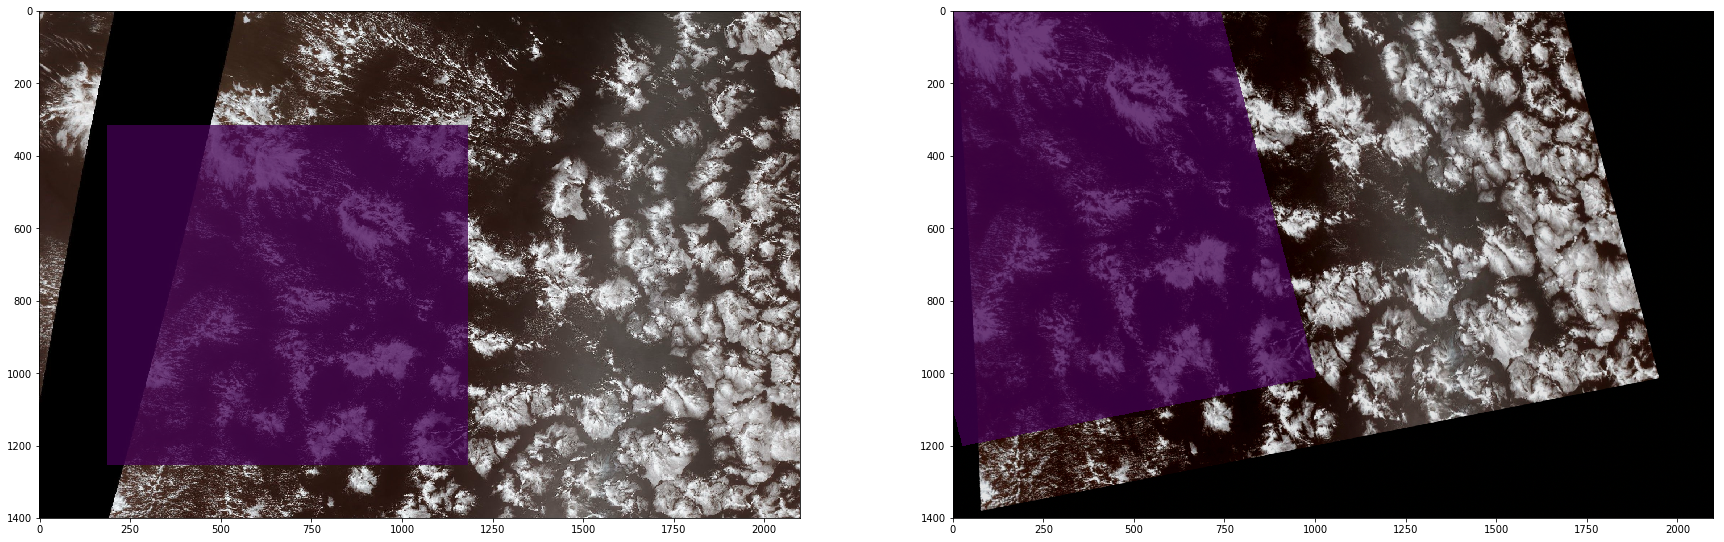

In [6]:
cloud_img_id = df.sample().index[0] # get a random index

image_path = os.path.join(train_image_path, df['Image'][cloud_img_id])
clouds_img = cv2.imread(image_path)

# Define our augmentation pipeline.
# You can find more augmenters here: https://imgaug.readthedocs.io/en/latest/source/overview_of_augmenters.html
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)

(image_aug, augmented_rle, augmented_mask, augmented_segmap) = augment(cloud_img_id, seq)

plt_image(img1=clouds_img, mask1=get_mask(cloud_img_id), img2=image_aug, mask2=augmented_mask)